# Importing libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from transformers import AutoTokenizer, AutoModel
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import torch
import nltk
from lazypredict.Supervised import LazyClassifier
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import string
from wordcloud import WordCloud
from nltk import bigrams
from nltk.collocations import BigramAssocMeasures
from nltk.probability import FreqDist
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
# visualization
import pyLDAvis
import pyLDAvis.gensim_models
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import networkx as nx
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import loguniform
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.cloud import bigquery
import logging

# Parameters

In [4]:
date = '20230912'
sql_table_input = 'tefgfs.CSS_CallData_NLP.call_text_location_{}'.format(date)
sql_table_output = 'tefgfs.CSS_CallData_NLP.call_text_predictions_{}'.format(date)
labeled_files = ['Data/231106_Labeling KI Files_x1121.xlsx',
                'Data/1 - 2500 Fertig 1.xlsx',
                'Data/2501 - 5000 final.xlsx']
log_name = 'Run_Copy'

# Logging

In [5]:
from src.logger import create_logger

In [6]:
logger = create_logger(log_name, 'Logs/{}_{}_run.log'.format(date, log_name))

# Load data

In [7]:
# Load labeled data.
df_labeled = pd.DataFrame()
for f in labeled_files:
    df1 = pd.read_excel(f)
    df_labeled = pd.concat([df_labeled, df1], ignore_index=True).drop_duplicates(subset=['content'])
df_labeled.head(2)

,AP,Ariadne_internal_ID,content,cnt,VVL Mobile,VVL DSL,PO GA,I@H GA,TV GA,OOC (out of category),Comment,Conditional Formatting,Bearbeitungszeit
0,Katrin Kühne,FA163E153AE3-1b27-eeeaa700-77b26-64e3046f-1555...,Herzlich willkommen beim O Kundenservice mein ...,54,False,False,False,False,False,False,NaN,0,NaN
1,Katrin Kühne,FA163E153AE3-1b27-eeeaa700-77d03-64e3074a-24e4...,Guten Morgen bei O sie sprechen mit Alexandra ...,61,False,False,True,False,False,False,NaN,1,NaN


In [8]:
# Load the unlabeled data from BQ.
df_unlabeled = bigquery.Client().query("SELECT * FROM `{}`".format(sql_table_input)).to_dataframe()
df_unlabeled.head(2)

,filename,content,SOM,location,call_duration,Ariadne_internal_ID
0,SOM_118_00513_FA163E622DEB-1a7e-e29da700-832c3...,Herzlich willkommen bei O sein uns am Apparat ...,SOM,118,513,FA163E622DEB-1a7e-e29da700-832c3-64e3520f-7cef...
1,SOM_118_00513_FA163E52FD32-1a7e-2da87700-aa52c...,Willkommen bei der O Kundenbetreuung sie sprec...,SOM,118,513,FA163E52FD32-1a7e-2da87700-aa52c-64e76b65-aec3...


In [9]:
df = pd.concat([df_labeled, df_unlabeled], axis = 0, ignore_index = True)
df.head(2)

,AP,Ariadne_internal_ID,content,cnt,VVL Mobile,VVL DSL,PO GA,I@H GA,TV GA,OOC (out of category),Comment,Conditional Formatting,Bearbeitungszeit,filename,SOM,location,call_duration
0,Katrin Kühne,FA163E153AE3-1b27-eeeaa700-77b26-64e3046f-1555...,Herzlich willkommen beim O Kundenservice mein ...,54.00,False,False,False,False,False,False,NaN,0.00,NaN,NaN,NaN,NaN,<NA>
1,Katrin Kühne,FA163E153AE3-1b27-eeeaa700-77d03-64e3074a-24e4...,Guten Morgen bei O sie sprechen mit Alexandra ...,61.00,False,False,True,False,False,False,NaN,1.00,NaN,NaN,NaN,NaN,<NA>


# Data preprocessing

In [10]:
# TODO: Instead of using FunctionTransformers with these functions in the pipeline,
# create a custom transformer:
# from sklearn.base import BaseEstimator, TransformerMixin
# class CustomTransformer(BaseEstimator, TransformerMixin):
# https://www.andrewvillazon.com/custom-scikit-learn-transformers/
# that implements a fit, fit_transform and a transform method, so that
# the data processing can be trained on labeled data (e.g. saving the most frequent words to be removed to an attribute of the class)
# and then applied to unlabeled data (removing exactly the SAME words, using the attribute of the class)
# The functions below can be functions of the new custom transformer.
# When the new class works, extract it to a .py file and import it so that it doesn't take so much space here.

def remove_columns(df, columns_to_remove = ['AP','Ariadne_internal_ID','cnt', 'Comment', 'Conditional Formatting']):
    # Drop the specified columns
    df = df.drop(columns=columns_to_remove, axis=1, errors='ignore')
    return df

def remove_missing_data(df, column='content'):
    # Check for missing data in the entire DataFrame
    missing_data = df.isnull().sum()
    if (missing_data > 0).sum()>0:
        # Print missing data counts for each column
        logger.info("Missing Data Counts:")
        logger.info(missing_data)
        df.dropna(subset=['content'], inplace=True)
    return df

nlp = spacy.load('de_core_news_sm')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def remove_punctuation(df, column='content'):
    df['text'] = df['content'].apply(lambda x: ' '.join([token.text for token in nlp(x) if token.pos_!='PROPN']))
    df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return df

def preprocess_text(text):
    # Initialize the Snowball stemmer and WordNet lemmatizer
    stemmer = SnowballStemmer("german")  # Use the appropriate language for stemming
    lemmatizer = WordNetLemmatizer()

    # Tokenize the text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('german'))  # Use the appropriate language
    tokens = [word for word in tokens if word not in stop_words]
    
    # Remove short words (length < 3 characters)
    tokens = [word for word in tokens if len(word) > 2]
    
    # Lemmatize or stem the words
    # Uncomment one of the following lines based on your choice
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    
    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

def process_text(df):
    # Apply the preprocessing function to the DataFrame
    df['text'] = df['text'].apply(preprocess_text)
    return df

def get_unique_number_of_words(df):
    word_set = set()
    for row in df["text"]:
        word_set.update(row.split(" "))
    logger.info('Unique number of words: {}'.format(len(word_set)))
    return df

def remove_frequent_words(df):
    # select the 100 most frequent words
    most_frequent = Counter(" ".join(df["text"]).split()).most_common(100)
    logger.info(', '.join([el[0] for el in most_frequent]))

    # Words to remove
    words_to_remove =  most_frequent + ["herr", "hallo", "willkomm", "herzlich", "mal", "tun", "tag", "nam", "guck", "sau", "bitt", 
                                       "halt", "gerad", "weil", "desweg", "gruss", "schon", "abend", "irgendwie", "schau", "nachmittag", "aha",
                                       "gott", "frau", "opus", "herrn", "irgendwo", 'bitt', 'mal', 'schon', 'genau', 'dank', 'gut', 'tag', 'numm', 'person', 'kurz', 
                       'einfach', 'neu', 'schau', 'moment', 'sag', 'muss', 'geht', 'fall', 'ganz', 'war', 'gern', 'frag', 
                       'gleich',
                      'guck', 'imm', 'halt', 'wurd', 'seh', 'natur', 'quasi', 'gerad', 'bekomm', 'rout', 'gesagt', 'nein', 
                       'tun', 'syst',
                      'mehr', 'mocht', 'box', 'geh', 'zugangsdat', 'passwort', 'kennwort', 'steht','seit', 'klein', 'bekomm', 'rufnumm', 
                       'kundenkennzahl', 'leid', 'tun', 'nam', 'per', 'willkomm', 'herzlich', 'gemacht', 'bleib', 'herr',
                       'kolleg',
                       'schick', 'frau', 'geb', 'richtig', 'vielleicht', 'viel','kart', 'brot', 'brauch',
                      'erst', 'gibt', 'kommt', 'moglich',  'pro', 'iphon', 'sekund', 'minut', 'wirklich', 'krieg',
                       'tatsach', 'musst', 'weiss',  'darf', 'find', 'gar', 'probl' , 'nee', 'klar', 'tschuss', 'heut', 'uhr', 'anruf', 
                       'wunsch', 'dat' , 'hallo', 'kundig', 'ich', 'habe']


    # Function to remove specified words from text
    def remove_specific_words(text, words_to_remove):
        # Tokenize the text
        tokens = text.split(" ")

        # Filter out words to remove
        filtered_tokens = [word for word in tokens if word not in words_to_remove]

        # Join the remaining tokens back into a single string
        cleaned_text = ' '.join(filtered_tokens)
        return cleaned_text

    # Apply the function to the 'cleaned_text' column
    df['text'] = df['text'].apply(lambda x: remove_specific_words(x, words_to_remove))
    return df

def tokenize_with_sliding_window(text, window_size=512, step_size=256):
    tokens = []
    for i in range(0, len(text), step_size):
        chunk = text[i:i + window_size]
        tokens.extend(tokenizer.encode(chunk, add_special_tokens=True))
    return tokens
                          
def calculate_word_count(df):
    # Split the 'content' column into words and calculate word counts
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

    # Calculate the average word count
    average_word_count = df['word_count'].mean()

    # Print the average word count
    logger.info("Average Word Count: {}".format(average_word_count))

    # Calculate the average word count
    average_word_count_median = df['word_count'].median()

    # Print the average word count
    logger.info("Median Word Count: {}".format(average_word_count_median))


    # Print the max word count
    logger.info("Max Word Count: {}".format(df['word_count'].max()))

    # Print the min word count
    logger.info("Min Word Count: {}".format(df['word_count'].min()))
    
    # Find the text with the minimum number of words
    min_word_count = df['word_count'].min()
    min_word_text = df[df['word_count'] == min_word_count]['text'].values[0]

    # Print the text with the minimum word count
    logger.info("Text with the Minimum Number of Words:")
    logger.info(min_word_text)

    # Optionally, you can also print the word count for reference
    logger.info(f"Word Count: {min_word_count}")
    
    # Create a histogram of the word counts
    plt.hist(df['word_count'], bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.title('Histogram of Word Counts in Texts')
    plt.show()

    return df


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
targets = ['Sales', 'VVL Mobile', 'VVL DSL', 'PO GA','I@H GA', 'TV GA']
df['Sales'] = pd.NA
df.loc[(pd.notnull(df['VVL Mobile'])), 'Sales'] = df[(pd.notnull(df['VVL Mobile']))][['VVL Mobile', 'VVL DSL', 'PO GA', 'I@H GA', 'TV GA']].sum(axis=1)>0
df.loc[(pd.notnull(df['VVL Mobile'])), targets] = df.loc[(pd.notnull(df['VVL Mobile'])), targets].astype(bool).astype(int)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
pipe = Pipeline([('remove_columns', FunctionTransformer(remove_columns, kw_args={'columns_to_remove': ['AP','Ariadne_internal_ID','cnt', 'Comment', 'Conditional Formatting', 'SOM', 'Bearbeitungszeit', 'location', 'call_duration']})),
                 ('remove_missing_data', FunctionTransformer(remove_missing_data, kw_args={'column': 'content'})), 
                 ('remove_punctuation', FunctionTransformer(remove_punctuation, kw_args={'column': 'content'})), 
                 ('process_text', FunctionTransformer(process_text)),
                ('get_unique_number_of_words', FunctionTransformer(get_unique_number_of_words)),
                ('remove_frequent_words', FunctionTransformer(remove_frequent_words)),
                ('calculate_word_count', FunctionTransformer(calculate_word_count))], verbose = True)

[Pipeline] .... (step 1 of 7) Processing remove_columns, total=   0.1s
[Pipeline]  (step 2 of 7) Processing remove_missing_data, total=   0.2s
[Pipeline]  (step 3 of 7) Processing remove_punctuation, total=228.6min
[Pipeline] ...... (step 4 of 7) Processing process_text, total=11.5min


--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 104

[Pipeline]  (step 5 of 7) Processing get_unique_number_of_words, total=   3.8s
[Pipeline]  (step 6 of 7) Processing remove_frequent_words, total= 2.2min


--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 104

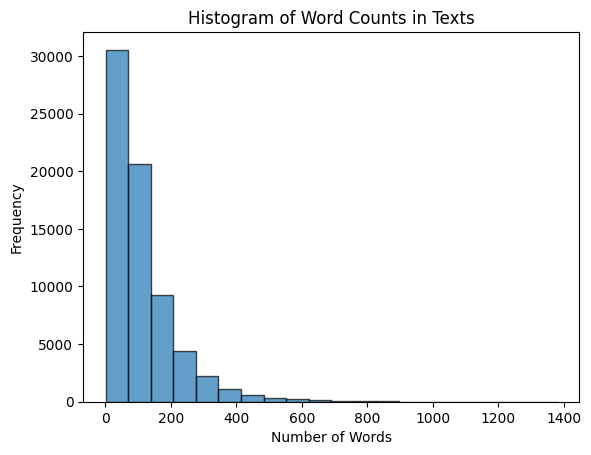

[Pipeline]  (step 7 of 7) Processing calculate_word_count, total=   1.8s


In [13]:
df_processed = pipe.fit_transform(df)

In [15]:
# Saving here because processing runs a long time.
df_processed.to_csv('df_processed.csv', index = False)

In [16]:
# If you don't have time to wait for processing, load from here.
df_processed = pd.read_csv('df_processed.csv')

In [17]:
df_labeled = df_processed[(pd.notnull(df_processed['VVL Mobile']))].copy()
df_unlabeled = df_processed[(pd.isnull(df_processed['VVL Mobile']))].copy()

In [18]:
targets = ['Sales', 'VVL Mobile', 'VVL DSL', 'PO GA','I@H GA', 'TV GA']
counts = df_labeled[targets].apply(pd.Series.value_counts)
counts.reset_index(inplace=True)
counts

,index,Sales,VVL Mobile,VVL DSL,PO GA,I@H GA,TV GA
0,0.00,4048,4833,4980,4288,4950,4891
1,1.00,952,167,20,712,50,109


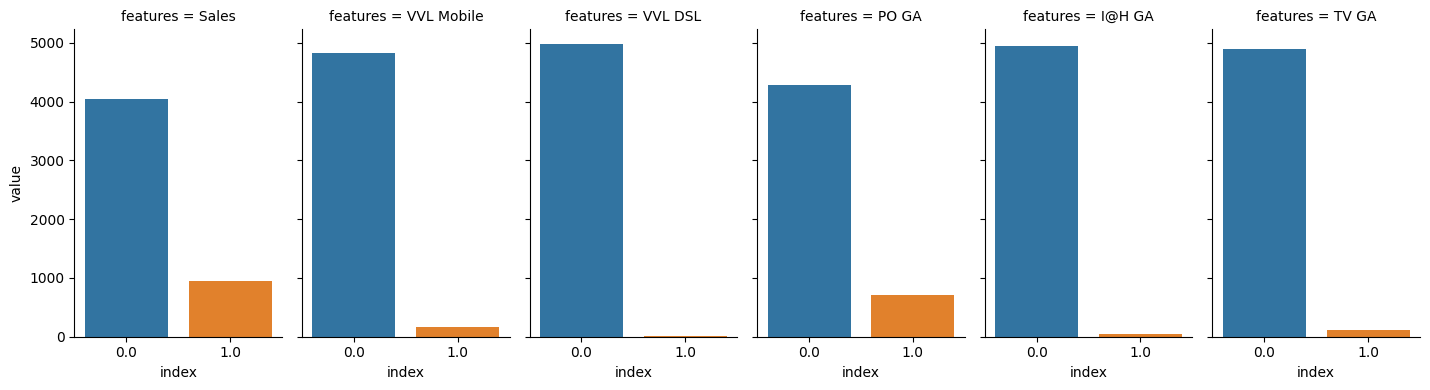

In [19]:
sns.catplot(
    data=counts.melt(id_vars=['index'], var_name='features'), 
    x='index', y='value', col='features',
    kind="bar", height=4, aspect=.6,
)

# Topic Modelling

In [ ]:
# TODO: move to .py file
# def perform_topic_modeling(df):
#     # Tokenize the text and create a dictionary
#     def tokenize(text):
#         return text.split()

#     texts_content = [tokenize(text) for text in df['text']]

#     # Create a dictionary from the tokenized text
#     dictionary_content = corpora.Dictionary(texts_content)

#     # Create document-term matrices
#     corpus_content = [dictionary_content.doc2bow(text) for text in texts_content]

#     # Perform LDA
#     num_topics =5
#     lda_model_content = gensim.models.LdaModel(corpus=corpus_content, id2word=dictionary_content, num_topics=num_topics)

#     # Print topics for the 'content' DataFrame
#     logger.info("Topics for the 'content' DataFrame:")
#     logger.info(lda_model_content.print_topics(num_words=5))

#     # Evaluation
#     coherence_model_content = CoherenceModel(model=lda_model_content, texts=texts_content, dictionary=dictionary_content, coherence='c_v')
#     coherence_content = coherence_model_content.get_coherence()

#     # Compute Perplexity a measure of how good the model is. lower the better.
#     logger.info('\nContent Perplexity: ', lda_model_content.log_perplexity(corpus_content))  

#     # Compute Coherence Score for lda_model_content
#     logger.info('\nContent Coherence Score: ', coherence_content)
    
#     # Create a function to generate and display word clouds for each topic
#     def generate_word_clouds(lda_model, num_topics):
#         for topic_num in range(num_topics):
#             words = lda_model.show_topic(topic_num, topn=20)  # Get the top 20 words for each topic
#             wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))

#             plt.figure(figsize=(10, 5))
#             plt.imshow(wordcloud, interpolation='bilinear')
#             plt.title(f"Topic {topic_num}")
#             plt.axis("off")
#             plt.show()

#     # Assuming you have already defined lda_model_content and num_topics
#     generate_word_clouds(lda_model_content, num_topics)

#     # Assuming you have a list of tokenized texts stored in 'texts_content'
#     # Join the tokens back into sentences
#     sentences = [' '.join(tokens) for tokens in texts_content]

#     # Tokenize the sentences again (if needed)
#     tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

#     # Create a BigramCollocationFinder
#     finder = BigramCollocationFinder.from_documents(tokenized_sentences)

#     # Set the association measure (you can adjust this)
#     bigram_measures = BigramAssocMeasures()
#     finder.apply_freq_filter(5)  # Adjust the frequency filter as needed

#     # Get the top bigrams
#     top_bigrams = finder.nbest(bigram_measures.pmi, 10)  # You can change the number of top bigrams

#     # Create a graph to represent word associations
#     G = nx.Graph()

#     # Add nodes and edges for the bigrams
#     for bigram in top_bigrams:
#         word1, word2 = bigram
#         G.add_node(word1)
#         G.add_node(word2)
#         G.add_edge(word1, word2)

#     # Create a figure and axis explicitly
#     plt.figure(figsize=(10, 8))
#     ax = plt.gca()

#     # Define layout for the nodes
#     pos = nx.spring_layout(G)

#     # Draw the graph
#     nx.draw(G, pos, with_labels=True, font_size=12, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold', ax=ax)
#     plt.title("Word Association Graph (Top Bigrams)")
#     plt.show()


In [ ]:
# perform_topic_modeling(df_labeled)

In [ ]:
# perform_topic_modeling(df_unlabeled)

# Model selection

In [20]:
from src.models import fit_vectorizer, select_best_models
# TODO: different loss function for BERT in src.bert.py

In [21]:
features = ['text'] 
X_train, X_test = train_test_split(df_labeled[features + targets], test_size=0.2, random_state=42)
X_train[targets] = X_train[targets].astype('bool').astype(int)
X_test[targets] = X_test[targets].astype('bool').astype(int) 
logger.info('Training: {}, Testing: {}'.format(len(X_train), len(X_test)))

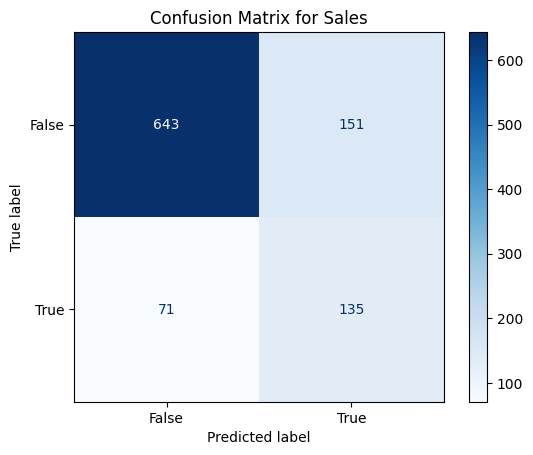

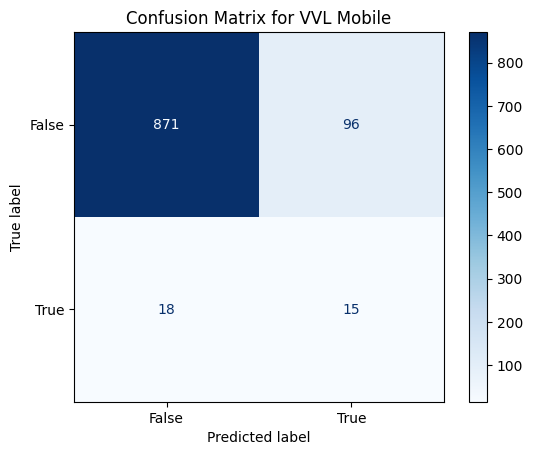

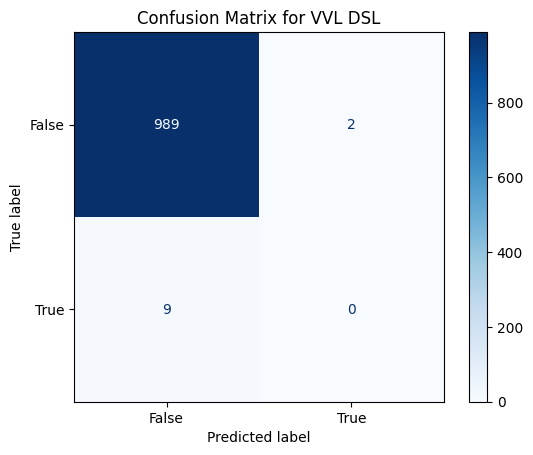

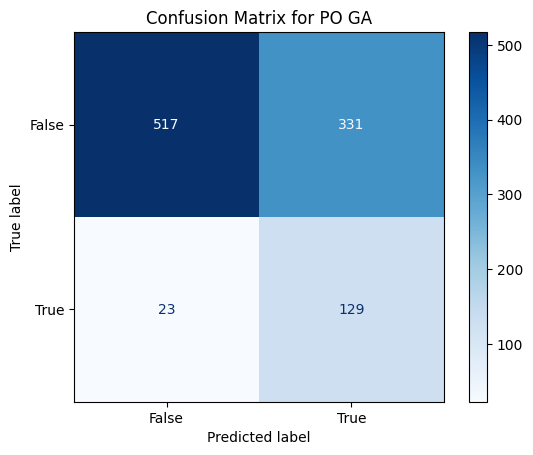

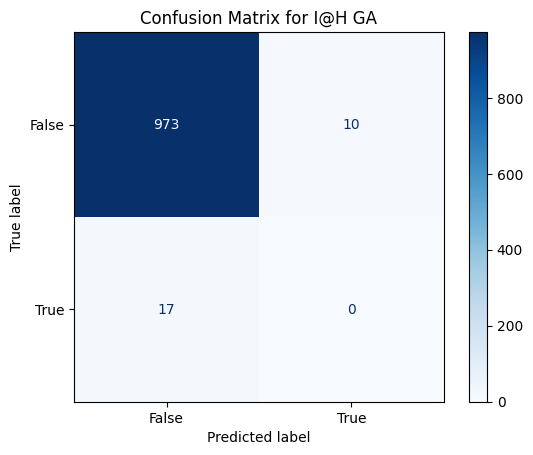

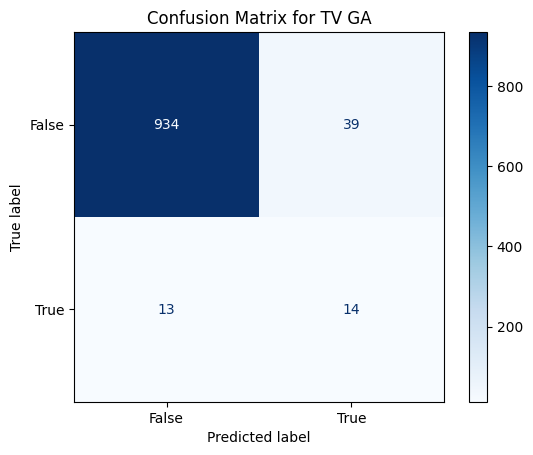

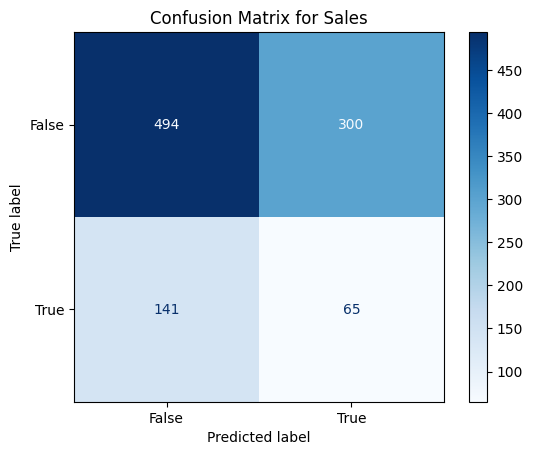

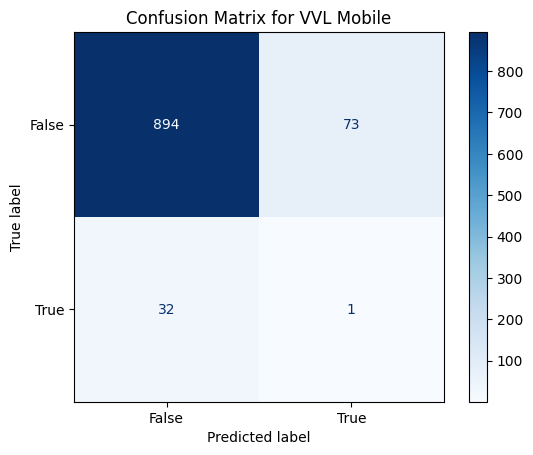

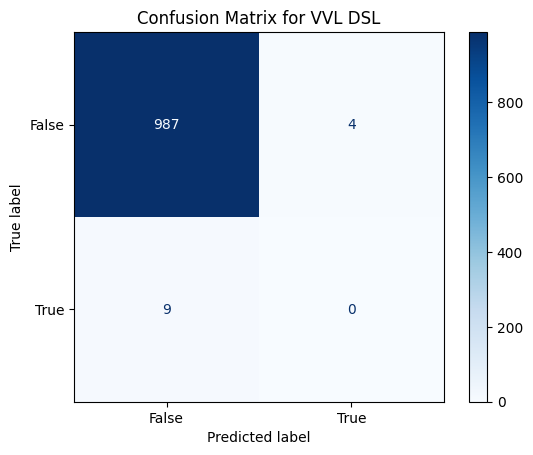

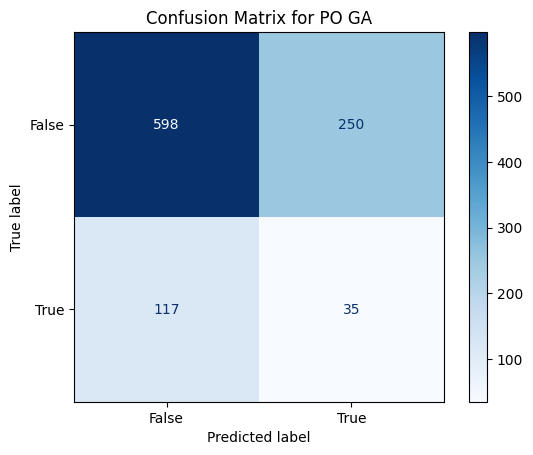

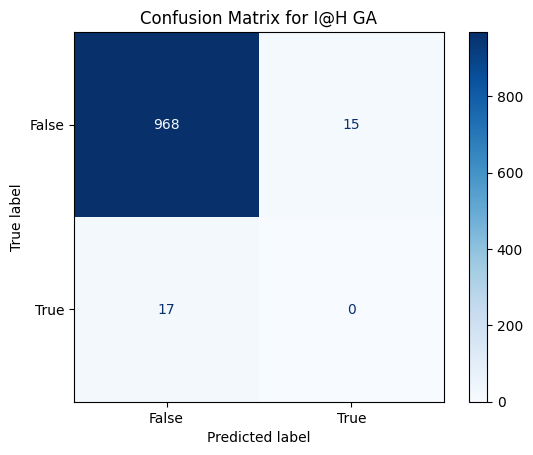

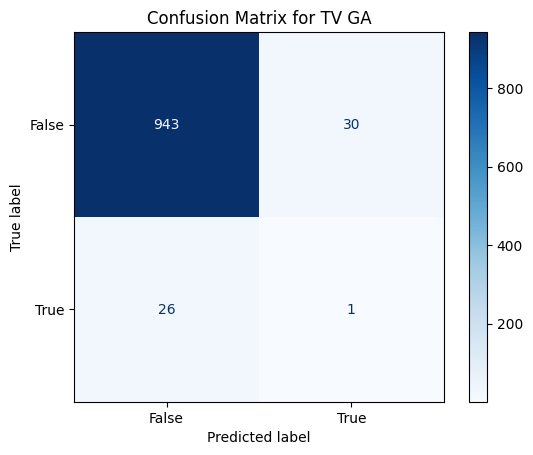

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationW

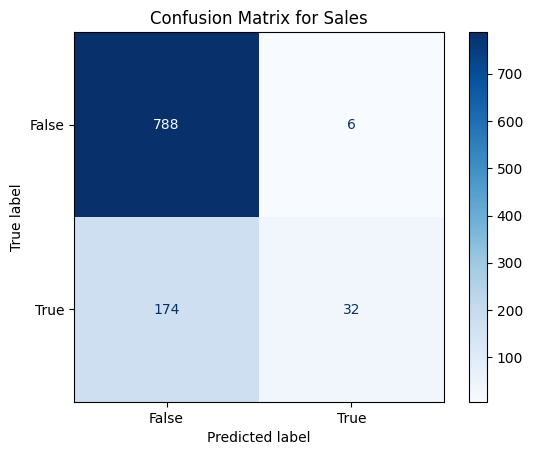

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationW

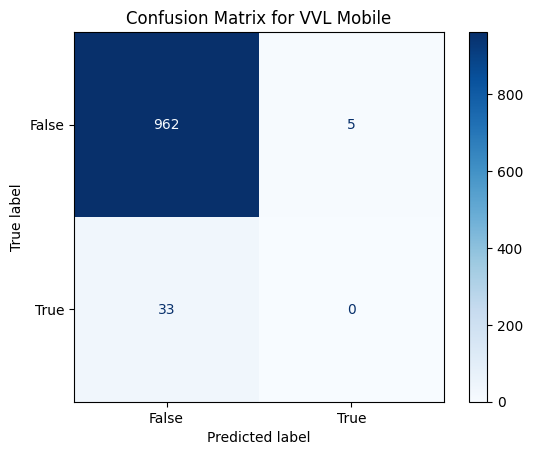

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationW

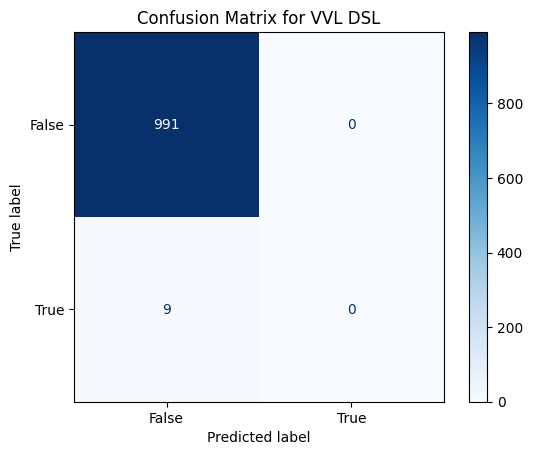

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationW

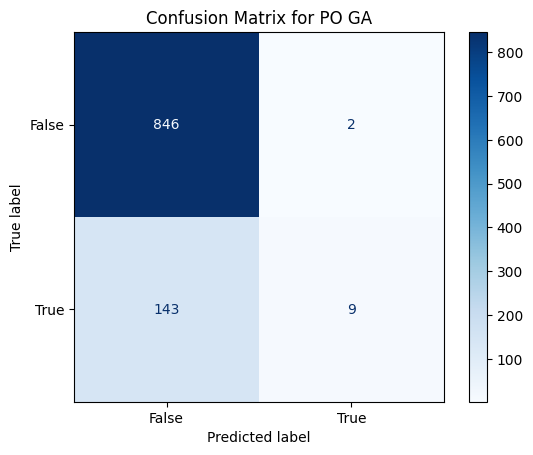

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationW

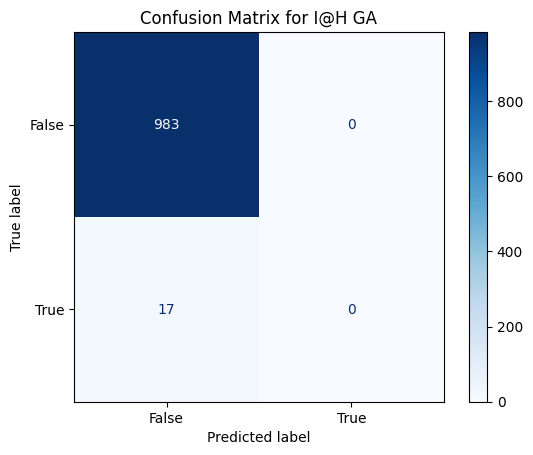

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  yield param_grid[i]
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:313: DeprecationW

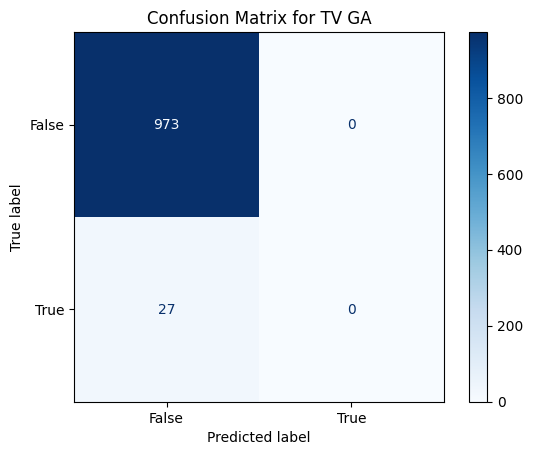

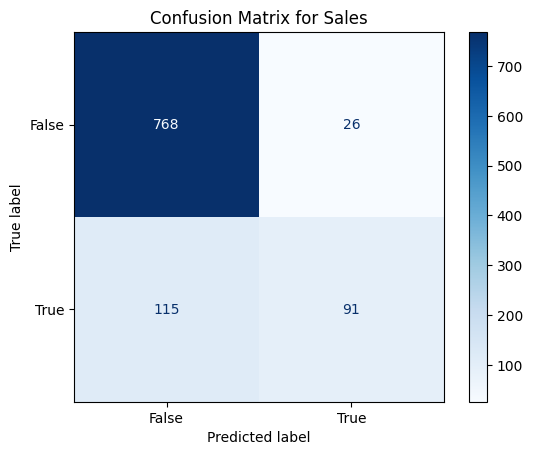

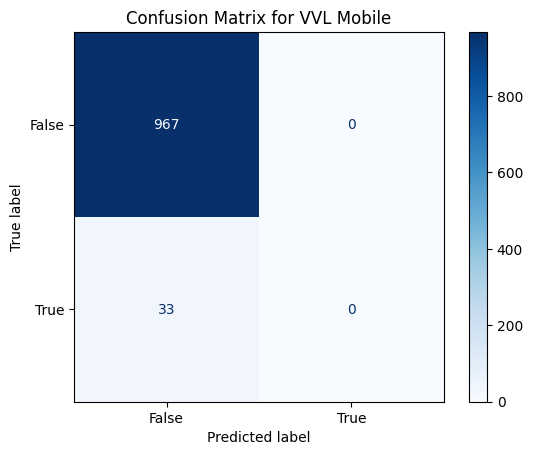

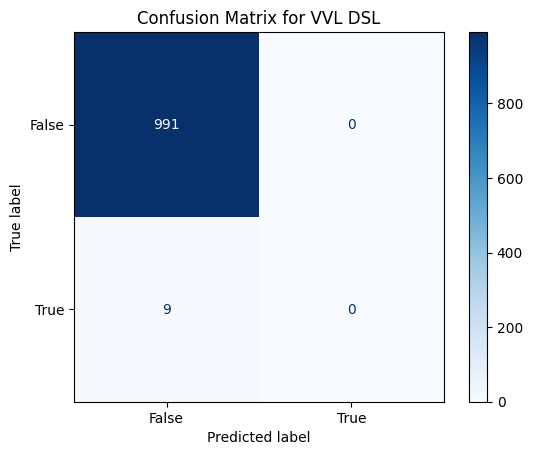

In [ ]:
selected_models, best_models = select_best_models(
    X_train, X_test, ['BERT', 'CNB', 'NB', 'RF', 'ADA', 'GP', 'KNN'], 
    targets, metric='roc_auc', results_filename = "model_results.xlsx", logger=logger, verbose=True)

In [ ]:
logger.info('Best models:')
logger.info(best_models)

## Predict unlabeled data

In [ ]:
# Todo put in function and move to src.models.py
logger.info('Predicting unlabeled data')
vectorizer = fit_vectorizer(X_train)
dfs = np.array_split(df_unlabeled, 10) # Otherwise vectorization takes too much memory.
for dfu in dfs:
    unlabeled_vectors = vectorizer.transform(dfu["text"])
    for variable in targets:
        if best_models[best_models.target==variable].model.iat[0] == "BERT":
            dfu[variable+'_PROB'] = best_models[best_models.target==variable].best_model.iat[0].predict_proba(df_unlabeled)[variable]
        else:
            dfu[variable+'_PROB'] = best_models[best_models.target==variable].best_model.iat[0].predict_proba(unlabeled_vectors.toarray())[:,1]
    no_sales = 1*((dfu[[t for t in targets if t!='Sales']]>0).sum(axis=1)==0)
    dfu['prediction'] = 'No Sales'
    dfu.loc[no_sales==1, 'prediction'] = dfu[no_sales==1][[t+'_PROB' for t in targets if t!='Sales']].idxmax(axis=1)
df_unlabeled = pd.concat([dfu for dfu in dfs], axis = 0, ignore_index=True)

In [ ]:
relevant_cols = ['filename', 'content', 'prediction'] + [c for c in df_unlabeled.columns if c.endswith('PROB')]
renamed_cols = [c.replace(' ', '_').translate(str.maketrans('', '', '@')) for c in relevant_cols]
df_unlabeled.rename(columns =  dict(zip(relevant_cols, renamed_cols)), inplace=True)
df_unlabeled[renamed_cols].head(2)

# Upload to BQ

In [ ]:
df_unlabeled[renamed_cols].to_gbq(
        destination_table = sql_table_output, 
        project_id='tefgfs', 
        if_exists='replace', progress_bar=True)
logger.info('Uploaded to BQ.')